# extractDirectionality

## Imports

In [5]:
import pandas as pd
import re 
import json
import datetime
import os
import time
import glob
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Subroutines
Subroutines neccessary for extractDirectionality
timeExtract takes the log file to be parsed, and returns the start time and end time in a tuple:<br>
    [startTime, endTime]<br>
<br>
durationinMicroseconds takes the log file to be parsed, and it returns the total duration, startTime, and endTime:<br>
    duration, startTime, endTime

In [6]:
# Extract time information of each recording from the log file
def timeExtract(filename):
    with open(filename, 'rb') as f:
        # Start counting from the last byte
        counter = 1
        # Go to the 2nd byte before the end of the last line
        f.seek(-2, 2) 
        while f.read(1) != b'\n':
            f.seek(-2, 1)
            counter=counter+1
        endTime_line = f.readline().decode()
        # Go to the 2nd byte before the end of the last second line
        f.seek(-counter-2, 2)
        while f.read(1) != b'\n':
            f.seek(-2, 1)
        startTime_line = f.readline().decode()

    return [startTime_line, endTime_line]

In [7]:
# Calculate duration of each recording in microseconds
def durationinMicroseconds(filename):
    startTime = timeExtract(filename)[0].split()[2:]
    endTime = timeExtract(filename)[1].split()[2:]
    startTimeStr = startTime[0] + ' ' + startTime[1]
    endTimeStr = endTime[0] + ' ' + endTime[1]
    T1 = datetime.datetime.strptime(startTimeStr, '%Y-%m-%d %H:%M:%S.%f')
    T2 = datetime.datetime.strptime(endTimeStr, '%Y-%m-%d %H:%M:%S.%f')
    delta = T2-T1
    duration = delta.seconds*1000000 + delta.microseconds
    
    return duration, T1, T2

## Function: extractDirectionalities
Decription:<br>
extractDirectionalities accepts a log file generated from data collected from an ODAS microphone, it will then organize the file into a dataframe, where each data point is time, direction, and strength of a single source.<br><br>
Parameters:<br>
**log file path, Microphopne Number**<br><br>
Returns a dataframe with the following columns:<br> 
**Timestamp, Time, Time In Seconds, Microphone Number, ID, X, Y, Z, Activity** <br>


In [8]:
def extractDirectionalities(filename, mic_number):
    with open(filename, 'r') as f:
        text = f.read()

        # Use repex to store blocks of data into a list
    data = re.split('(?<=})\n(?={)', text) 
        # Delete the time info from the last data block
    tmp = data[-1][:(data[-1].rfind("}")+1)]
    data[-1] = tmp
        
    #list of src blocks 

    srcList = [json.loads(block)["src"] for block in data]

    
    #initialize dataframe to have colums: timestamp, time, data inside source
    #timestamp is the initial time stamp
    #time is the datetime value converted from the timestamp and intitial time
    #source is a 4 by 6 array where the rows are the source, and the columns are the source values
    df = pd.DataFrame(columns = ['Timestamp', 'Time', 'Time In Seconds', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    
    #Used for calculating timestamps -> time
    duration, startTime, endTime = durationinMicroseconds(filename)
    start_time_in_seconds = time.mktime(startTime.timetuple())
    t = duration/len(data) / 1000000
    
    index = 1.0
    ind = 0
    df_dict = {}
    for block in srcList:
        if block[0]["id"] != 0 or block[1]["id"] != 0 or block[2]["id"] != 0 or block[3]["id"] != 0:
            time_in_seconds = start_time_in_seconds + (index - 1.0) * t
            for i in range(0, 4):
                if block[i]['id'] != 0:
                    df_dict[ind] = {"Timestamp": [index], "Time":datetime.datetime.fromtimestamp(time_in_seconds).strftime("%A, %B %d, %Y %I:%M:%S"), "Time In Seconds": time_in_seconds, "Microphone Number":mic_number, "Source ID": block[i]["id"], "X": block[i]["x"], "Y": block[i]["y"], "Z": block[i]["z"], "Activity": block[i]["activity"]}
                    ind = ind + 1
                    #df = df.append(pd.DataFrame({"Timestamp": [index], "Time":datetime.datetime.fromtimestamp(time_in_seconds).strftime("%A, %B %d, %Y %I:%M:%S"), "Time In Seconds": time_in_seconds, "Microphone Number":mic_number, "Source ID": block[i]["id"], "X": block[i]["x"], "Y": block[i]["y"], "Z": block[i]["z"], "Activity": block[i]["activity"]}, index=[0]))
        index = index + 1.0
    
    df = df.append(pd.DataFrame.from_dict(df_dict,"index"))
    return(df)
            

## Function: mergeDirectionalities
Decription: <br>
mergeDirectionalities will iterate through all the files in "data" folder, and it will use extractDirectionalities create each file into a dataframe. The dataframe created will be appended into a master dataframe consiting of all the dataframes created from using extractDirectionalities on each file in "data" folder. <br>

Prerequirements:<br>
All folders in "data" folder must be filled with desired .log files in their respective recordingx folders.To do this, run the function above to automate it, or manually download the files from google drive and insert them into the correct folders.<br><br>

Parameters:<br>
None.<br><br>

Returns a dataframe with the following columns:<br> 
**Timestamp, Time, Time In Seconds, Microphone Number, ID, X, Y, Z, Activity** <br>

In [5]:
def mergeDirectionalities():   
    #create dataframe
    df = pd.DataFrame(columns = ['Timestamp', 'Time', 'Time In Seconds', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    for i in range(4):
        for filename in glob.glob("/Users/brian_wangst/Google Drive File Stream/My Drive/ODAS/recordings" + str(i) + "/*.log"):
        #for filename in glob.glob("notast4ing"):
            with open(filename, 'r') as f:
                firstline = f.readline()
            if firstline == "SST log contains no useful data\n":
                pass
            else:
                df1 = extractDirectionalities(filename, i)
                df = df.append(df1)
            
    df = df.sort_values(['Time In Seconds'])
    return df

## Function: directionalitiesOfMicrophone

Description:<br>
directionalitiesOfMicrophone takes the directory of all the log files produced by a single microphone, and it will create a dataframe from that data.<br><br>
Parameters:<br>
String representation of the path from the home directory to the directory of the log files of the given microphone.<br><br>
Returns a dataframe with the following columns:<br> 
**Timestamp, Time, Time In Seconds, Microphone Number, ID, X, Y, Z, Activity** <br>

In [5]:
def diectionalitiesOfMicrophone(microphone_directory):
    df = pd.DataFrame(columns = ['Timestamp', 'Time', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    for filename in glob.glob(microphone_directory +  "*.log"):
        with open(filename, 'r') as f:
            firstline = f.readline()
        if firstline == "SST log contains no useful data\n":
            pass
        else:
            df1 = extractDirectionalities(filename, i)
            df = df.append(df1)
    return df

# K Clustering

## Imports

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d

In [9]:
data0 = extractDirectionalities("/Users/ardelalegre/CSE4223-ODAS/data/recordings0/cSSt_2019-09-09_14_55_03.log", 0)

X = data[['X', 'Y', 'Z']].values

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

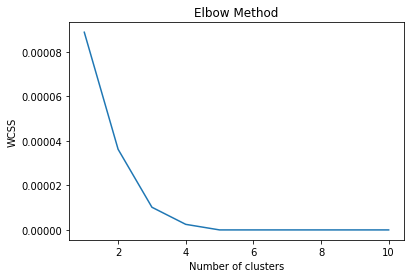

In [46]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

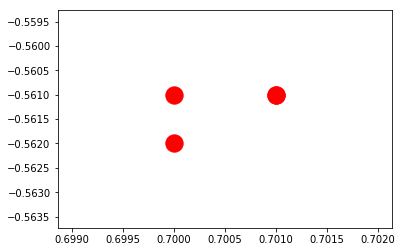

In [75]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1], X[:,2])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

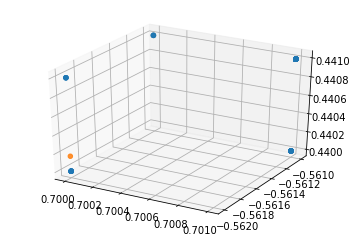

In [72]:
ax = plt.axes(projection='3d')
ax.scatter(data['X'].values,data['Y'].values, data['Z'])
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2])

In [68]:
d = mergeDirectionalities()

NameError: name 'notast4ing' is not defined

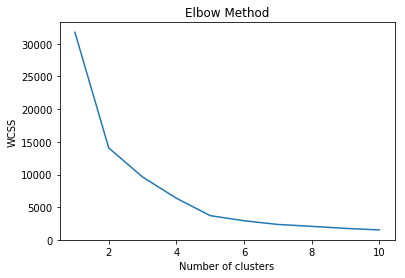

In [32]:
x = d[['X', 'Y', 'Z']].values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=3000, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

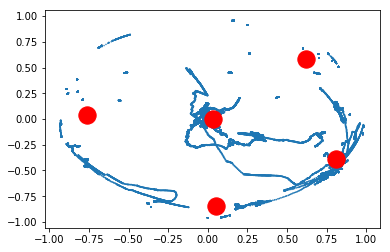

In [33]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(x)
plt.scatter(x[:,0], x[:,1], x[:,2])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

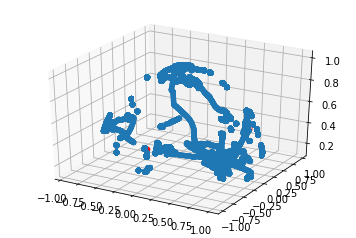

In [34]:
ax = plt.axes(projection='3d')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red')
ax.scatter(d['X'].values,d['Y'].values, d['Z'])

2020-01-08-09-25-03
## K means for January 8

In [9]:
def to_CSV(mic_number):
    dataframe = pd.DataFrame(columns = ['Timestamp', 'Time', 'Time In Seconds', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    for filename in glob.glob("/Users/brian_wangst/Google Drive File Stream/My Drive/ODAS/recordings" + str(mic_number) + "/*.log"):
        if("2020-01-08" in filename):
            print(filename)
            with open(filename, 'r') as f:
                firstline = f.readline()
                if firstline == "SST log contains no useful data\n":
                    pass
            try:
                dataframe = extractDirectionalities(filename, mic_number)
                dataframe.to_csv(path_or_buf='/home/ardelalegre/CSE4223-ODAS/data/recordings' + str(mic_number) + '/' + filename[48:filename.find('.log')] + '.csv')
            except KeyboardInterrupt:
                print(nothing)
            except:
                print("Error with " + filename)
    return dataframe   

In [14]:
def combine_CSV():
    print("entered top")
    master_list = []
    count = 0
    total = 0
    records0 = glob.glob("/home/brianwang/google-drive/ODAS/recordings" + str(0) + "/*.log")
    records1 = glob.glob("/home/brianwang/google-drive/ODAS/recordings" + str(1) + "/*.log")
    records2 = glob.glob("/home/brianwang/google-drive/ODAS/recordings" + str(2) + "/*.log")
    records3 = glob.glob("/home/brianwang/google-drive/ODAS/recordings" + str(3) + "/*.log")
    flag = 0
    curDay = ""
    count = 0
    records0.sort()
    records1.sort()
    records2.sort()
    records3.sort()
    for mic0,mic1,mic2,mic3 in zip(records0,records1,records2,records3):
        if mic0.find('cSST') == -1:
            continue
        extractDay = mic0[mic0.find('cSST') + 5: mic0.find('cSST') + 10 + 5]
#         os.rename(mic0, mic0[:mic0.find("cSST")] + "seen" + mic0[mic0.find("cSSt"):] )
        
        if flag == 0:
            curDay = extractDay
            flag = 1
            
        if curDay != extractDay:
            dict_to_csv(master_list)
            master_list = []
            flag = 0
            
        if((extractDay in mic0) or (extractDay in mic1) or (extractDay in mic2) or (extractDay in mic3)):
            with open(mic0, 'r') as f:
                firstline = f.readline()
                if firstline == "SST log contains no useful data\n":
                    pass
            with open(mic1, 'r') as f:
                firstline = f.readline()
                if firstline == "SST log contains no useful data\n":
                    pass
            with open(mic2, 'r') as f:
                firstline = f.readline()
                if firstline == "SST log contains no useful data\n":
                    pass
            with open(mic3, 'r') as f:
                firstline = f.readline()
                if firstline == "SST log contains no useful data\n":
                    pass
            try:
                print("entering extract directionalities")
                print("found extracDay on" + extractDay)
                print("Before extracting mic 0")
                
                try:
                    df0 = extractDirectionalities(mic0, 0)
                except:
                    print("error with mic0")
                try:
                    df1 = extractDirectionalities(mic1, 1)
                except:
                    print("error with mic1")
                try:
                    df2 = extractDirectionalities(mic2, 2)
                except:
                    print("error with mic2")
                try:
                    df3 = extractDirectionalities(mic3, 3)
                except:
                    print("error with mic 3")

                print("before dictoinary")
                
                try:
                    for index, row in df0.iterrows():
                        dic = {}
                        dic['Timestamp'] = row['Timestamp']
                        dic['Time'] = row['Time']
                        dic['Time In Seconds'] = row['Time In Seconds']
                        dic['Microphone Number'] = row['Microphone Number']
                        dic['Source ID'] = row['Source ID']
                        dic['X'] = row['X']
                        dic['Y'] = row['Y']
                        dic['Z'] = row['Z']
                        dic['Activity'] = row['Activity']
                        master_list.append(dic)
               
                except:
                    print("")
                try:  
                    for index, row in df1.iterrows():
                        dic = {}
                        dic['Timestamp'] = row['Timestamp']
                        dic['Time'] = row['Time']
                        dic['Time In Seconds'] = row['Time In Seconds']
                        dic['Microphone Number'] = row['Microphone Number']
                        dic['Source ID'] = row['Source ID']
                        dic['X'] = row['X']
                        dic['Y'] = row['Y']
                        dic['Z'] = row['Z']
                        dic['Activity'] = row['Activity']
                        master_list.append(dic)
                except:
                    print("")
                try:   
                    for index, row in df2.iterrows():
                        dic = {}
                        dic['Timestamp'] = row['Timestamp']
                        dic['Time'] = row['Time']
                        dic['Time In Seconds'] = row['Time In Seconds']
                        dic['Microphone Number'] = row['Microphone Number']
                        dic['Source ID'] = row['Source ID']
                        dic['X'] = row['X']
                        dic['Y'] = row['Y']
                        dic['Z'] = row['Z']
                        dic['Activity'] = row['Activity']
                        master_list.append(dic)
                except:
                    print("")
                    
                try:
                    for index, row in df3.iterrows():
                        dic = {}
                        dic['Timestamp'] = row['Timestamp']
                        dic['Time'] = row['Time']
                        dic['Time In Seconds'] = row['Time In Seconds']
                        dic['Microphone Number'] = row['Microphone Number']
                        dic['Source ID'] = row['Source ID']
                        dic['X'] = row['X']
                        dic['Y'] = row['Y']
                        dic['Z'] = row['Z']
                        dic['Activity'] = row['Activity']
                        master_list.append(dic)
                except:
                    print("")
            except:
                print("")

In [11]:
def dict_to_csv(master_list):
    if len(master_list) == 0:
        return
    master_list = sorted(master_list, key = lambda i: i['Time In Seconds'])            
    masterDataFrame = pd.DataFrame(master_list)
    beginTime = masterDataFrame['Time In Seconds'].iloc[0]
    split = beginTime + 3600
    hour = 0
    counter = 0
    master_sorted_list = []
    for index, row in masterDataFrame.iterrows():
        beginTime = row['Time In Seconds']
        if beginTime < split:
            dic = {}
            dic['Timestamp'] = row['Timestamp']
            dic['Time'] = row['Time']
            dic['Time In Seconds'] = row['Time In Seconds']
            dic['Microphone Number'] = row['Microphone Number']
            dic['Source ID'] = row['Source ID']
            dic['X'] = row['X']
            dic['Y'] = row['Y']
            dic['Z'] = row['Z']
            master_sorted_list.append(dic)
        else:
            hourlyCSV = pd.DataFrame(master_sorted_list)
            hourlyCSV['tempMic'] = hourlyCSV['Microphone Number'].shift(-1)
            hourlyCSV['tempTime'] = hourlyCSV['Time In Seconds'].shift(-1)
            hourlyCSV['Multi Source'] = (hourlyCSV['Microphone Number'] != hourlyCSV['tempMic']) 
            hourlyCSV = hourlyCSV.drop(columns = ['tempMic','tempTime'])
            hourlyCSV.to_csv(path_or_buf='/home/brianwang/Downloads/CSVData/' + str(hourlyCSV['Time'][0]) + "hour" + str(hour) + '.csv')
            hour = hour + 1
            master_sorted_list = []
            split = beginTime + 3600
            
    hourlyCSV = pd.DataFrame(master_sorted_list)        
    hourlyCSV['tempMic'] = hourlyCSV['Microphone Number'].shift(-1)
    hourlyCSV['tempTime'] = hourlyCSV['Time In Seconds'].shift(-1)
    hourlyCSV['Multi Source'] = (hourlyCSV['Microphone Number'] != hourlyCSV['tempMic'])
    hourlyCSV = hourlyCSV.drop(columns = ['tempMic','tempTime'])
    hourlyCSV.to_csv(path_or_buf='/home/brianwang/Downloads/CSVData/' + str(hourlyCSV['Time'][0]) + "hour" + str(hour) + '.csv')

In [12]:
# zero = to_CSV(0)
combine_CSV()



entered top
['/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-09-29_15:35:03.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-10-30_12:45:04.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-09-28_23:50:03.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-10-30_02:35:04.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-12-11_11:55:03.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-12-08_23:25:03.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-12-06_23:30:03.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-09-15_17:25:04.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-09-28_10:50:03.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-12-08_11:10:03.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-10-09_23:45:04.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST_2019-09-09_16:25:04.log', '/home/brianwang/google-drive/ODAS/recordings0/cSST

entering extract directionalities
found extracDay on2019-09-29
Before extracting mic 0
error with mic0
error with mic1
error with mic2


/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


before dictoinary



entering extract directionalities
found extracDay on2019-10-30
Before extracting mic 0
error with mic0
error with mic1
error with mic 3
before dictoinary


entering extract directionalities
found extracDay on2019-09-28
Before extracting mic 0
error with mic0
error with mic2
before dictoinary



KeyboardInterrupt: 

In [21]:
one = to_CSV(1)

NameError: name 'to_CSV' is not defined

In [22]:
two = to_CSV(2)

NameError: name 'to_CSV' is not defined

In [112]:
three = to_CSV(3)

NameError: name 'to_CSV' is not defined

In [11]:
def csv_to_dataframe(mic_number):
    df = pd.DataFrame(columns = ['Timestamp', 'Time', 'Time In Seconds', 'Microphone Number', 'Source ID', 'X', 'Y', 'Z', 'Activity'])
    for filename in glob.glob("/home/ardelalegre/CSE4223-ODAS/data/recordings" + str(mic_number) + '/*.csv'):
        df = df.append(pd.read_csv(filename))
    return df

In [12]:
df0 = csv_to_dataframe(0)
df1 = csv_to_dataframe(1)
df2 = csv_to_dataframe(2)
df3 = csv_to_dataframe(3)

/home/ardelalegre/.local/lib/python3.5/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [14]:
df0.head()


,Activity,Microphone Number,Source ID,Time,Time In Seconds,Timestamp,Unnamed: 0,X,Y,Z
0,0.864,0,19,"Wednesday, January 08, 2020 10:06:13",1.578507e+09,8847.0,0.0,-0.0,-0.0,1.0
1,0.313,0,19,"Wednesday, January 08, 2020 10:06:13",1.578507e+09,8848.0,0.0,-0.0,-0.0,1.0
2,0.133,0,19,"Wednesday, January 08, 2020 10:06:13",1.578507e+09,8849.0,0.0,-0.0,-0.0,1.0
3,0.143,0,19,"Wednesday, January 08, 2020 10:06:13",1.578507e+09,8850.0,0.0,-0.0,-0.0,1.0
4,0.504,0,19,"Wednesday, January 08, 2020 10:06:13",1.578507e+09,8851.0,0.0,-0.0,-0.0,1.0


In [18]:
df = pd.concat([df0, df1, df2, df3])
df = df.sort_values(['Time In Seconds'])
df

,Activity,Microphone Number,Source ID,Time,Time In Seconds,Timestamp,Unnamed: 0,X,Y,Z
0,0.802,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33421.0,0.0,-0.066,0.021,0.998
1,0.854,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33422.0,0.0,-0.066,0.021,0.998
2,0.612,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33423.0,0.0,-0.066,0.021,0.998
3,0.726,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33424.0,0.0,-0.066,0.021,0.998
4,0.797,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33425.0,0.0,-0.066,0.021,0.998
5,0.925,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33426.0,0.0,-0.066,0.021,0.998
6,0.693,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33427.0,0.0,-0.066,0.021,0.998
7,0.796,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33428.0,0.0,-0.066,0.021,0.998
8,0.385,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33429.0,0.0,-0.066,0.021,0.998
9,0.657,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33430.0,0.0,-0.066,0.021,0.998


In [56]:
arr = np.array(df['Microphone Number'])
#arr = arr[4000000:]
dff = arr[1:] - arr[:-1]
dff = dff != 0
dff = np.append(dff, 0)
df['diff']  = dff
df

,Activity,Microphone Number,Source ID,Time,Time In Seconds,Timestamp,Unnamed: 0,X,Y,Z,diff
0,0.802,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33421.0,0.0,-0.066,0.021,0.998,0
1,0.854,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33422.0,0.0,-0.066,0.021,0.998,0
2,0.612,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33423.0,0.0,-0.066,0.021,0.998,0
3,0.726,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33424.0,0.0,-0.066,0.021,0.998,0
4,0.797,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33425.0,0.0,-0.066,0.021,0.998,0
5,0.925,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33426.0,0.0,-0.066,0.021,0.998,0
6,0.693,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33427.0,0.0,-0.066,0.021,0.998,0
7,0.796,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33428.0,0.0,-0.066,0.021,0.998,0
8,0.385,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33429.0,0.0,-0.066,0.021,0.998,0
9,0.657,0,5,"Wednesday, January 08, 2020 12:14:30",1.578471e+09,33430.0,0.0,-0.066,0.021,0.998,0


In [57]:
df.to_csv("combinedFor1-8-20.csv")

In [59]:
!ls -lh combinedFor1-8-20.csv

-rw-rw-r-- 1 ardelalegre ardelalegre 910M Feb 21 09:55 combinedFor1-8-20.csv


In [ ]:
index = np.where(dff)[0]
index[:100]

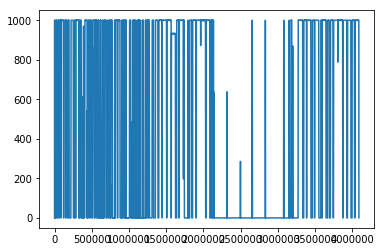

In [41]:
kernel = np.ones(1000)
smooth = np.convolve(dff, kernel)
plt.plot(smooth)

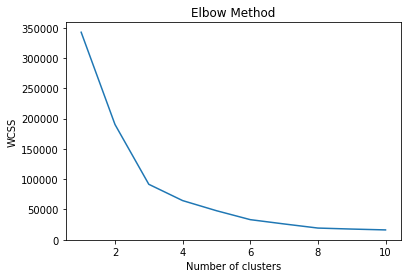

In [22]:
x = df3[['X', 'Y', 'Z']].values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=3000, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


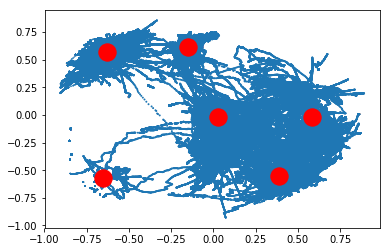

In [25]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(x)
plt.scatter(x[:,0], x[:,1], x[:,2])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

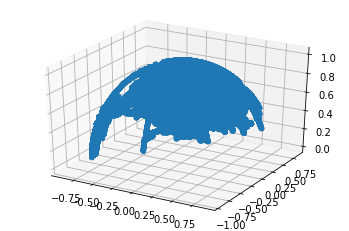

In [24]:
ax = plt.axes(projection='3d')
#ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red')
ax.scatter(df['X'].values,df['Y'].values, df['Z'].values)

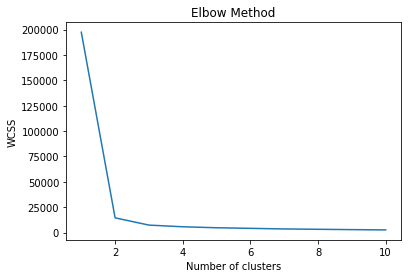

In [12]:
x = df0[['X', 'Y', 'Z']].values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=3000, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

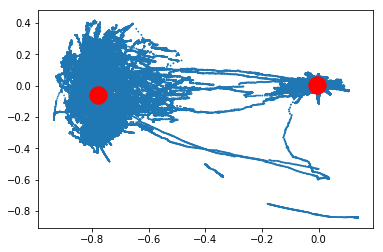

In [14]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(x)
plt.scatter(x[:,0], x[:,1], x[:,2])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

NameError: name 'df' is not defined

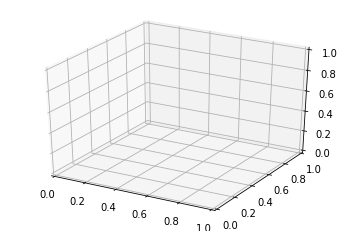

In [15]:
ax = plt.axes(projection='3d')
#ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red')
ax.scatter(df['X'].values,df['Y'].values, df['Z'].values)